# Import Libraries

In [117]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

%matplotlib inline
seed = 0
np.random.seed(seed)

tf.random.set_seed(seed)

os.environ['XILINX_VITIS'] = '/tools/Xilinx/Vitis/2023.2'
os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']

# Simulate Dataset

In [118]:
# -- Parameters --
fs         = 378e3        # ADC sampling rate [Hz]
bit_res    = 20           # 20-bit resolution
I_FS       = 1e-3         # full-scale = ±1 mA
DIG_FS     = 52000        # device maps ±1 mA → ±52 000 counts
N          = 100_000      # total samples
f_sig      = 1e3          # setting sine wave frequency to 1 kHz
n_channels = 4            # number of ADC input/output channels
t = np.arange(N) / fs     # time scale

# same sinusoidal current on each channel
I_true = I_FS * np.sin(2 * np.pi* f_sig * t).astype(np.float32)
I_true_ch = np.tile(I_true.reshape(-1,1), (1, n_channels)) # duplicates array 4x for 4 channels

# each channel's gain/offset/noise
gains   = np.array([1.05, 0.98, 1.02, 1.10], dtype=np.float32)   # caste everything as 32-bit FP
offsets = np.array([ 100, -200,   50,    0], dtype=np.float32)
noise   = np.random.normal(0, 50, size=(N, n_channels)).astype(np.float32)

# raw ADC counts = ideal-counts * gain + offset + noise
ideal_dig = (I_true_ch / I_FS) * DIG_FS # the ideal digital value (ex. if I_true_ch = 0.5mA, then (0.5 / 1) * 52000 = 26000)
X_raw = ideal_dig * gains + offsets + noise # [w0 * x0 + b0 + b1]
X_raw = np.clip(X_raw, -DIG_FS, + DIG_FS).astype(np.float32) # saturates values out of range

y_counts = ideal_dig.astype(np.float32) # current that we want to predict

# Create Training-Test Split of Data

## 80% Training | 20% Testing

In [119]:
X = X_raw / DIG_FS
y = y_counts / DIG_FS      

# 20% for testing, 80% for training
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Scale data for NN to converge faster

In [120]:
#scaler = StandardScaler()
#X_train_val = scaler.fit_transform(X_train_val)
#X_test = scaler.transform(X_test)

print("Shapes:", X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape)

Shapes: (80000, 4) (80000, 4) (20000, 4) (20000, 4)


# Construct the Model

In [121]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

In [122]:
model = Sequential()
model.add(
    QDense(
        n_channels,
        input_shape=(n_channels,),
        name='calib_lin',
        kernel_quantizer=quantized_bits(bit_res, 1, alpha=1),
        bias_quantizer  =quantized_bits(bit_res, 1, alpha=1),
        kernel_initializer='lecun_uniform'
    )
)
model.add(
    Activation(
        'linear',
        name='linear_out'
    )
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 calib_lin (QDense)          (None, 4)                 20        
                                                                 
 linear_out (Activation)     (None, 4)                 0         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


# Don't meed to train with Sparsity

In [123]:
# you dont need to do sparsity for a model this simple

# Train the Model

In [124]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

train = True
if train:
    # 1) Compile with a light learning rate
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse',metrics=['mae'])

    # 2) Get your standard callbacks (early stopping, LR schedule, checkpoints)
    callbacks = all_callbacks(
        stop_patience=10,      # stop if no val_mae improvement for 10 epochs
        lr_factor=0.5,
        lr_patience=5,
        lr_epsilon=1e-6,
        lr_cooldown=2,
        lr_minimum=1e-7,
        outputDir='model_1',
    )

    # 3) Fit on your training split
    history = model.fit(
        X_train_val, 
        y_train_val, 
        batch_size=256,
        epochs=40,              # set a generous upper bound
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks
    )

    # 4) Save the best model
    model.save('model_1/calibrated_adc.h5')

else:
    # Reload with QKeras custom objects if needed
    from qkeras.utils import _add_supported_quantized_objects
    custom_objects = {}
    _add_supported_quantized_objects(custom_objects)
    model = load_model('model_1/calibrated_adc.h5', custom_objects=custom_objects)


Epoch 1/40
  1/235 [..............................] - ETA: 51s - loss: 1.5513 - mae: 1.0554WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0006s vs `on_train_batch_end` time: 0.0013s). Check your callbacks.


175/235 [=====================>........] - ETA: 0s - loss: 1.4694 - mae: 1.0205
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 1.37900, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 1.37900, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

235/235 [==============================] - 1s 1ms/step - loss: 1.4528 - mae: 1.0138 - val_loss: 1.3790 - val_mae: 0.9838 - lr: 1.0000e-04
Epoch 2/40
189/235 [=======================>......] - ETA: 0s - loss: 1.3205 - mae: 0.9593
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss improved from 1.37900 to 1.24057, saving model to model_1/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 1.37900 to 1.24057, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 2: saving 

# Evaluation Metrics

In [125]:
loss, mae_norm = model.evaluate(X_test, y_test, verbose=0)
# mae_norm is in normalized units → convert to counts then to µA:
mae_counts = mae_norm * DIG_FS
mae_amps   = (mae_counts / DIG_FS) * I_FS   # = mae_norm * I_FS
print(f"Test MAE = {mae_counts:.1f} counts = {mae_amps*1e6:.2f} µA")

Test MAE = 532.1 counts = 10.23 µA


625/625 [==============================] - 0s 476us/step


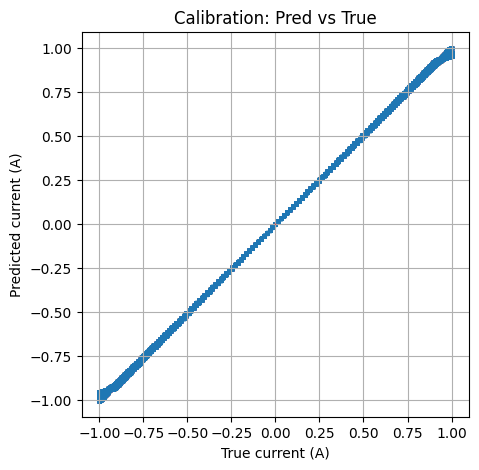

In [126]:
y_pred = model.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(y_test.flatten(), y_pred.flatten(), s=5, alpha=0.3)
lim = DIG_FS / (DIG_FS * I_FS)
plt.plot([-I_FS,I_FS], [-I_FS,I_FS], 'r--')
plt.xlabel("True current (A)")
plt.ylabel("Predicted current (A)")
plt.title("Calibration: Pred vs True")
plt.axis('equal')
plt.grid(True)
plt.show()

# Load Model

In [127]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
import os

os.environ['XILINX_VIVADO'] = '/tools/Xilinx/Vivado/2019.2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

model = load_model('model_1/calibrated_adc.h5', custom_objects=co)

# Convert to hls4ml model

In [129]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['calib_lin']['ReuseFactor'] = 64

print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj_calibrated_adc', backend='VivadoAccelerator', board='pynq-z2'
)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: calib_lin_input, layer type: InputLayer, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: calib_lin, layer type: QDense, input shapes: [[None, 4]], output shape: [None, 4]
Layer name: linear_out, layer type: Activation, input shapes: [[None, 4]], output shape: [None, 4]
-----------------------------------
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  calib_lin_input
    Trace:           False
    Precision
      result:        fixed<16,6>
  calib_lin
    Trace:           False
    Precision
      result:        fixed<16,6>
      weight:        fixed<20,2>
      bias:          fixed<20,2>
    ReuseFactor:     64
  calib_lin_linear
    Trace:           False
    Precision
      result:        fixed<16,6>
  linear_out
    Trace:           False
    Precision
      result:        fixed<16,6>
-------------------------

In [130]:
plotting.print_dict(hls4ml.backends.get_backend('VivadoAccelerator').create_initial_config())

Part:                xcvu13p-flga2577-2-e
ClockPeriod:         5
IOType:              io_parallel
HLSConfig
AcceleratorConfig
  Board:             pynq-z2
  Interface:         axi_stream
  Driver:            python
  Precision
    Input:           float
    Output:          float


# CPU Simulation of hls4ml model

In [131]:
X_test_c = np.ascontiguousarray(X_test)

# Run the HLS model in CPU (C-simulation) mode
y_hls = hls_model.predict(X_test_c)

# Save the HLS outputs for later comparison 
output_path = 'model_1/y_hls.npy'
np.save(output_path, y_hls)
print(f"HLS C-sim outputs saved to {output_path}")

HLS C-sim outputs saved to model_1/y_hls.npy


# Synthesize & Make Bitfile

In [132]:
hls_model.build(csim=False, synth=True, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'diag' on host 'WPS-175354' (Linux_x86_64 version 6.8.0-59-generic) on Mon Jun 23 10:07:34 EDT 2025
INFO: [HLS 200-10] On os Ubuntu 22.04.5 LTS
INFO: [HLS 200-10] In directory '/home/diag/Downloads/adc_calibration/model_1/hls4ml_prj_calibrated_adc'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Creating and opening project '/home/diag/Downloads/adc_calibration/model_1/hls4ml_prj_calibrated_adc/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '4.691',
  'BestLatency': '45',
  'WorstLatency': '45',
  'IntervalMin': '46',
  'IntervalMax': '46',
  'BRAM_18K': '0',
  'DSP': '1',
  'FF': '3142',
  'LUT': '3732',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 1.106,
  'TNS': 0.0,
  'WHS': 0.027,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

# Final Resource Usage

In [134]:
!sed -n '30,45p' model_1/hls4ml_prj_calibrated_adc/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt


+----------------------------+------+-------+-----------+-------+
|          Site Type         | Used | Fixed | Available | Util% |
+----------------------------+------+-------+-----------+-------+
| Slice LUTs                 | 3979 |     0 |     53200 |  7.48 |
|   LUT as Logic             | 3731 |     0 |     53200 |  7.01 |
|   LUT as Memory            |  248 |     0 |     17400 |  1.43 |
|     LUT as Distributed RAM |   22 |     0 |           |       |
|     LUT as Shift Register  |  226 |     0 |           |       |
| Slice Registers            | 5396 |     0 |    106400 |  5.07 |
|   Register as Flip Flop    | 5396 |     0 |    106400 |  5.07 |
|   Register as Latch        |    0 |     0 |    106400 |  0.00 |
| F7 Muxes                   |    2 |     0 |     26600 | <0.01 |
| F8 Muxes                   |    1 |     0 |     13300 | <0.01 |
+----------------------------+------+-------+-----------+-------+



In [ ]:
X_test_c = np.ascontiguousarray(X_test.astype(np.float32))
y_test_c = np.ascontiguousarray(y_test.astype(np.float32))

# save them next to your bitstream (or wherever your overlay code can load them)
np.save('model_1/X_test.npy', X_test_c)
np.save('model_1/y_test.npy', y_test_c)
